# **Машинное обучение ИБ-2024** Суровых Андрей БИБ223

# **Домашнее задание 2.**
# Классификация, KNN, LogReg, SVC.

In [1]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [2]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
    weight_arr = np.array(w)
    num_samples = X.shape[0]
    score = X.dot(weight_arr) + w0
    y_score_product = -y * score
    loss_values = np.log(1 + np.exp(y_score_product))

    return np.sum(loss_values) / num_samples + gamma * np.sum(np.abs(weight_arr)) + beta * np.sum(weight_arr**2)

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [3]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    weights_array, sample_count = np.array(w), X.shape[0]
    y_score_product = y * (X.dot(weights_array) + w0)
    temp_val = y / (1 + np.exp(y_score_product))
    grad_weights = - (1 / sample_count) * X.T.dot(temp_val) + gamma * np.sign(weights_array) + 2 * beta * weights_array
    grad_w0 = - (1 / sample_count) * np.sum(temp_val)

    return grad_weights.tolist(), grad_w0

In [4]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.loss_history = []

    def fit(self, X, y):
        np.random.seed(self.random_state)
        N, K = X.shape

        self.w = np.random.randn(K)
        self.w0 = np.random.randn()

        for _ in range(self.max_iter):
            current_loss = loss(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            self.loss_history.append(current_loss)

            grad_w, grad_w0 = get_grad(X, y, self.w, self.w0, gamma=self.gamma, beta=self.beta)
            grad_w = np.array(grad_w)

            w_new = self.w - self.lr * grad_w
            w0_new = self.w0 - self.lr * grad_w0

            if np.linalg.norm(w_new - self.w) < self.tolerance and abs(w0_new - self.w0) < self.tolerance:
                break

            self.w = w_new
            self.w0 = w0_new

        return self

    def predict(self, X):
        proba = self.predict_proba(X)[:, 1]
        return (proba >= 0.5).astype(int)

    def predict_proba(self, X):
        s = X.dot(self.w) + self.w0
        proba = 1 / (1 + np.exp(-s))
        return np.vstack([1 - proba, proba]).T


In [ ]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(model, X, y):
    boundary_colors = ('purple', 'blue')
    color_map = ListedColormap(boundary_colors)

    x_min_bound, x_max_bound = X[:, 0].min() - 1., X[:, 0].max() + 1.
    y_min_bound, y_max_bound = X[:, 1].min() - 1., X[:, 1].max() + 1.
    step = 0.01

    grid_x, grid_y = np.meshgrid(np.arange(x_min_bound, x_max_bound, step),
                                 np.arange(y_min_bound, y_max_bound, step))

    grid_coordinates = np.c_[grid_x.ravel(), grid_y.ravel()]
    predictions = model.predict(grid_coordinates)
    predictions = predictions.reshape(grid_x.shape)

    plt.figure(figsize=(10, 6))
    plt.contourf(grid_x, grid_y, predictions, alpha=0.3, cmap=color_map)
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap=color_map)
    plt.xlabel('Признак 1')
    plt.ylabel('Признак 2')
    plt.title('Граница решений')
    plt.show()

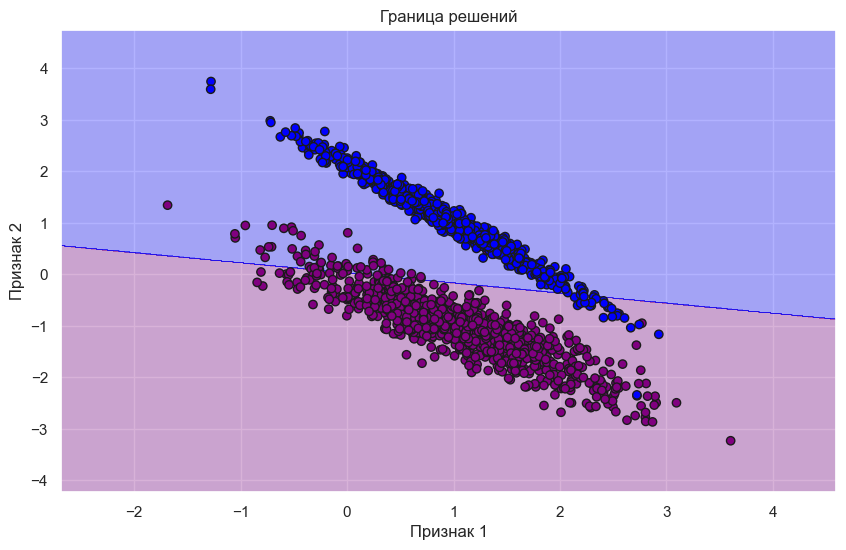

In [ ]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [ ]:
def plot_loss_history(model):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 6))
    plt.plot(model.loss_history, label='Loss')
    plt.xlabel('Номер итерации')
    plt.ylabel('Потери')
    plt.title('Функция потерь')
    plt.legend()
    plt.show()

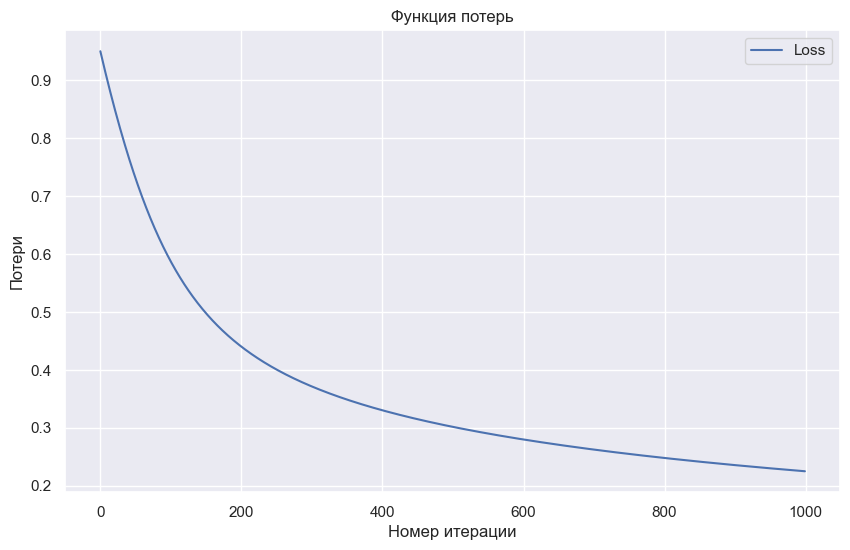

In [ ]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

Kernel: linear, C: 0.1
Accuracy: 0.8050, Precision: 0.7895, Recall: 0.7979, F1-Score: 0.7937, AUC-ROC: 0.9125
------------------------------------------------------------
Kernel: linear, C: 1
Accuracy: 0.8100, Precision: 0.7979, Recall: 0.7979, F1-Score: 0.7979, AUC-ROC: 0.9124
------------------------------------------------------------
Kernel: linear, C: 10
Accuracy: 0.8100, Precision: 0.7979, Recall: 0.7979, F1-Score: 0.7979, AUC-ROC: 0.9123
------------------------------------------------------------
Kernel: rbf, C: 0.1
Accuracy: 0.8850, Precision: 0.8447, Recall: 0.9255, F1-Score: 0.8832, AUC-ROC: 0.9519
------------------------------------------------------------
Kernel: rbf, C: 1
Accuracy: 0.9350, Precision: 0.9091, Recall: 0.9574, F1-Score: 0.9326, AUC-ROC: 0.9854
------------------------------------------------------------
Kernel: rbf, C: 10
Accuracy: 0.9550, Precision: 0.9293, Recall: 0.9787, F1-Score: 0.9534, AUC-ROC: 0.9908
--------------------------------------------------

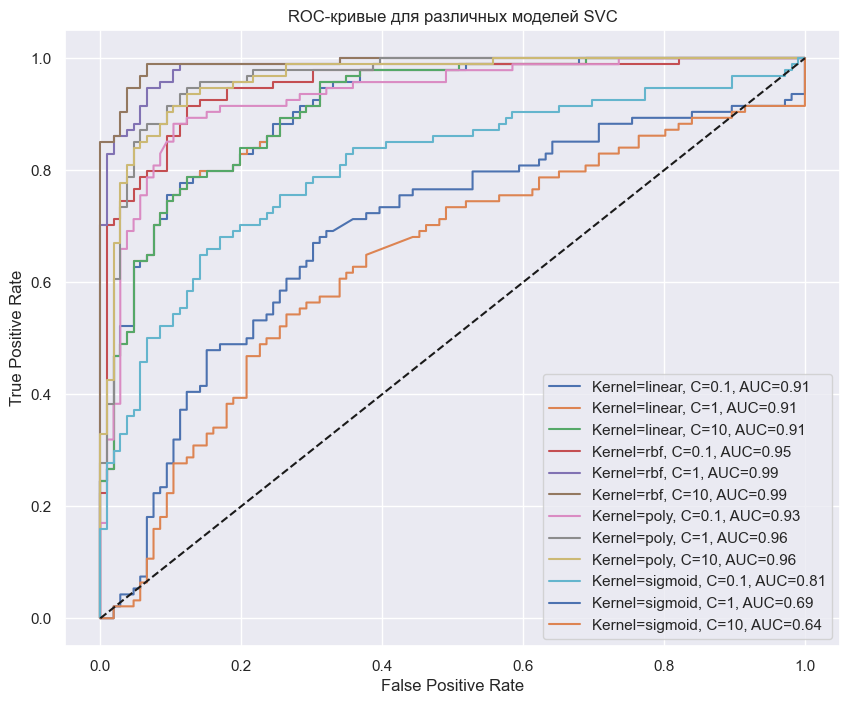

In [ ]:
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve)
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42)

kernel_types = ['linear', 'rbf', 'poly', 'sigmoid']
c_values, evaluation_results = [0.1, 1, 10], []

for kernel in kernel_types:
    for c in c_values:
        svc_model = SVC(kernel=kernel, C=c, probability=True, random_state=42)
        svc_model.fit(X_train, y_train)

        predicted_probs = svc_model.predict_proba(X_test)[:, 1]
        y_predicted = svc_model.predict(X_test)

        accuracy = accuracy_score(y_test, y_predicted)
        precision = precision_score(y_test, y_predicted)
        recall = recall_score(y_test, y_predicted)
        f1 = f1_score(y_test, y_predicted)
        auc_roc = roc_auc_score(y_test, predicted_probs)

        evaluation_results.append({
            'Kernel': kernel,
            'C': c,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC-ROC': auc_roc
        })

        print(f"Kernel: {kernel}, C: {c}")
        print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, "
              f"F1-Score: {f1:.4f}, AUC-ROC: {auc_roc:.4f}")
        print("-" * 60)


plt.figure(figsize=(10, 8))
for result in evaluation_results:
    svc_model = SVC(kernel=result['Kernel'], C=result['C'], probability=True, random_state=42)
    svc_model.fit(X_train, y_train)

    predicted_probs = svc_model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predicted_probs)
    plt.plot(fpr, tpr, label=f"Kernel={result['Kernel']}, C={result['C']}, AUC={result['AUC-ROC']:.2f}")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые для различных моделей SVC')
plt.legend()
plt.show()

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [ ]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)


class KNearestNeighbors:
    def __init__(self, num_neighbors=5, dist_metric='euclidean'):
        self.num_neighbors = num_neighbors
        self.dist_metric = dist_metric

    def fit(self, features, targets):
        self.train_features = np.array(features)
        self.train_targets = np.array(targets)
        self.unique_classes = np.unique(targets)

    def _calculate_distances(self, test_points):
        if self.dist_metric == 'euclidean':
            dists = np.sqrt(((self.train_features - test_points[:, np.newaxis]) ** 2).sum(axis=2))
        elif self.dist_metric == 'manhattan':
            dists = np.abs(self.train_features - test_points[:, np.newaxis]).sum(axis=2)
        else:
            raise ValueError("Метрика не поддерживается. Используйте 'euclidean' или 'manhattan'.")
        return dists

    def predict(self, test_points):
        test_points = np.array(test_points)
        dists = self._calculate_distances(test_points)
        nearest_ids = dists.argsort(axis=1)[:, :self.num_neighbors]
        nearest_labels = self.train_targets[nearest_ids]

        return np.array([Counter(labels).most_common(1)[0][0] for labels in nearest_labels])

    def predict_proba(self, test_points):
        test_points = np.array(test_points)
        dists = self._calculate_distances(test_points)
        nearest_ids = dists.argsort(axis=1)[:, :self.num_neighbors]
        nearest_labels = self.train_targets[nearest_ids]

        probabilities = []
        for labels in nearest_labels:
            counts = Counter(labels)
            total = sum(counts.values())
            class_probs = [counts.get(cls, 0) / total for cls in self.unique_classes]
            probabilities.append(class_probs)
        return np.array(probabilities)

X, y = make_classification(n_samples=1000, n_features=20, n_informative=15,
                           n_redundant=5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=88)

knn_model = KNearestNeighbors(num_neighbors=5, dist_metric='euclidean')

knn_model.fit(X_train, y_train)
pred_labels = knn_model.predict(X_test)
prob_labels = knn_model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, pred_labels)
precision = precision_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels)
f1 = f1_score(y_test, pred_labels)
auc_roc = roc_auc_score(y_test, prob_labels)

print(f"KNN метрики:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

KNN метрики:
Accuracy: 0.9150
Precision: 0.8974
Recall: 0.9545
F1-Score: 0.9251
AUC-ROC: 0.9672


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [ ]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('train.csv')
print(f"Форма набора данных: {dataset.shape}")

train_set = dataset.iloc[:50000]
test_set = dataset.iloc[50000:]

features_train = train_set.drop(['Category', 'Id'], axis=1).values
labels_train = train_set['Category'].values
features_test = test_set.drop(['Category', 'Id'], axis=1).values
labels_test = test_set['Category'].values


print(f"Форма обучающих данных: {features_train.shape}, Форма обучающих меток: {labels_train.shape}")
print(f"Форма тестовых данных: {features_test.shape}, Форма тестовых меток: {labels_test.shape}")

Форма набора данных: (60000, 786)
Форма обучающих данных: (50000, 784), Форма обучающих меток: (50000,)
Форма тестовых данных: (10000, 784), Форма тестовых меток: (10000,)


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

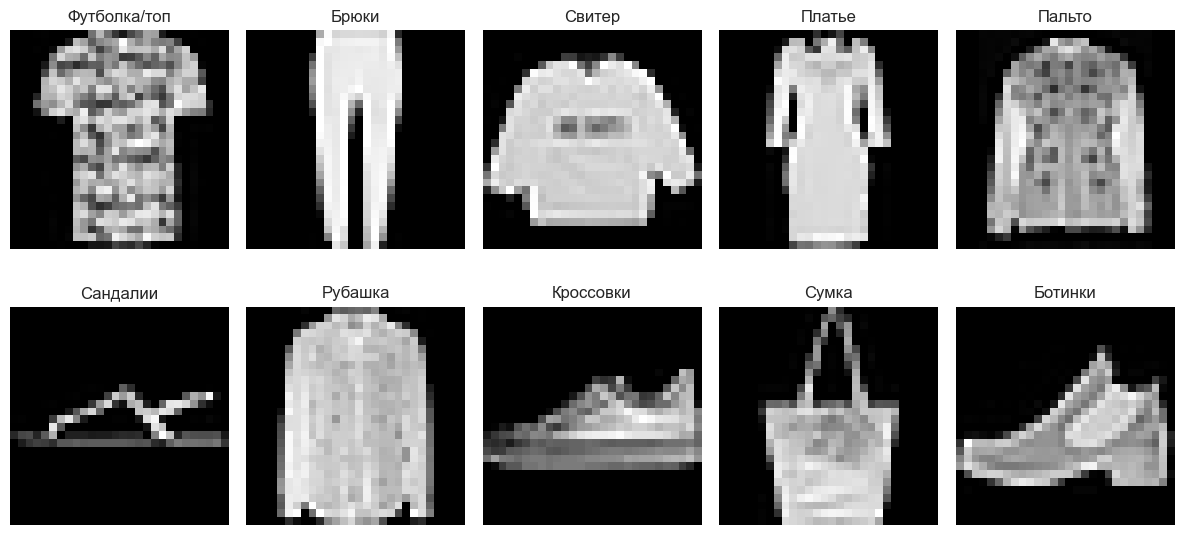

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

class_labels = ['Футболка/топ', 'Брюки', 'Свитер', 'Платье', 'Пальто',
                'Сандалии', 'Рубашка', 'Кроссовки', 'Сумка', 'Ботинки']

sample_examples = {}
for label in np.unique(labels_train):
    index = np.where(labels_train == label)[0][0]
    sample_examples[label] = features_train[index]

plt.figure(figsize=(12, 6))

for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(sample_examples[i].reshape(28, 28), cmap='gray')
    plt.title(class_labels[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler

dataset = pd.read_csv('train.csv')

training_data = dataset.iloc[:50000]
testing_data = dataset.iloc[50000:]

features_train = training_data.drop(['Category', 'Id'], axis=1).values
labels_train = training_data['Category'].values
features_test = testing_data.drop(['Category', 'Id'], axis=1).values
labels_test = testing_data['Category'].values

standard_scaler = StandardScaler()
features_train_standard = standard_scaler.fit_transform(features_train)
features_test_standard = standard_scaler.transform(features_test)

print("StandardScaler применён:")
print(f"Среднее значение признаков после масштабирования: {features_train_standard.mean(axis=0)[:5]}")
print(f"Стандартное отклонение признаков после масштабирования: {features_train_standard.std(axis=0)[:5]}")


minmax_scaler = MinMaxScaler()
features_train_minmax = minmax_scaler.fit_transform(features_train)
features_test_minmax = minmax_scaler.transform(features_test)

print("\nMinMaxScaler применён:")
print(f"Минимальное значение признаков после масштабирования: {features_train_minmax.min(axis=0)[:5]}")
print(f"Максимальное значение признаков после масштабирования: {features_train_minmax.max(axis=0)[:5]}")

StandardScaler применён:
Среднее значение признаков после масштабирования: [-6.76791956e-18 -1.66977543e-18  1.23456800e-18 -7.81597009e-18
 -1.42108547e-18]
Стандартное отклонение признаков после масштабирования: [1. 1. 1. 1. 1.]

MinMaxScaler применён:
Минимальное значение признаков после масштабирования: [0. 0. 0. 0. 0.]
Максимальное значение признаков после масштабирования: [1. 1. 1. 1. 1.]


#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

Объяснённая дисперсия 50 главными компонентами: 80.05%
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Лучшие параметры для KNN:
{'metric': 'manhattan', 'n_neighbors': 7, 'weights': 'distance'}
Лучшая кросс-валидационная точность: 0.8586
Fitting 5 folds for each of 32 candidates, totalling 160 fits


/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_clas


Лучшие параметры для логистической регрессии:
{'C': 10, 'max_iter': 200, 'multi_class': 'multinomial', 'penalty': 'l2', 'solver': 'lbfgs'}
Лучшая кросс-валидационная точность: 0.8320

Тестовая точность KNN: 0.8589

Отчёт о классификации для KNN:
              precision    recall  f1-score   support

           0       0.79      0.86      0.82      1001
           1       0.99      0.97      0.98       996
           2       0.79      0.78      0.78      1004
           3       0.90      0.87      0.89      1017
           4       0.74      0.78      0.76       997
           5       0.95      0.88      0.91       971
           6       0.67      0.62      0.64       986
           7       0.89      0.93      0.91      1003
           8       0.97      0.95      0.96      1017
           9       0.91      0.95      0.93      1008

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     1

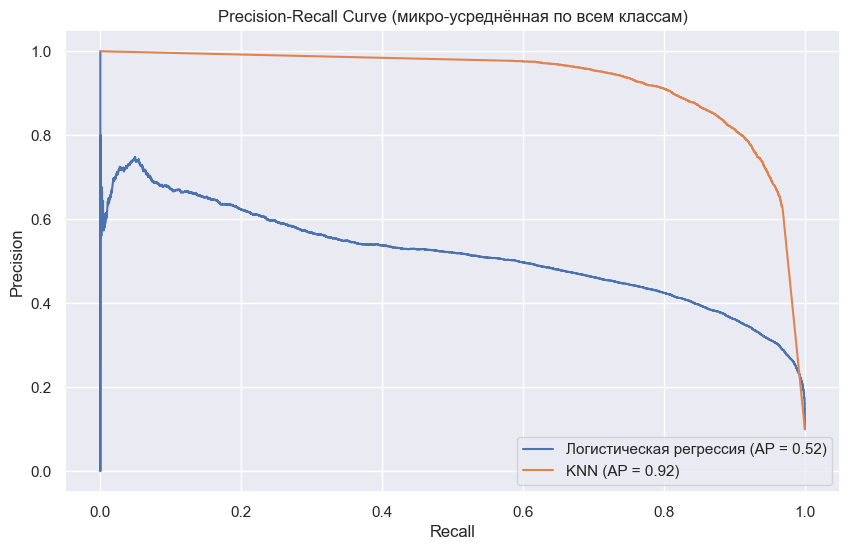

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

dataset = pd.read_csv('train.csv')
training_data = dataset.iloc[:50000]
testing_data = dataset.iloc[50000:]

features_train = training_data.drop(['Category', 'Id'], axis=1).values
labels_train = training_data['Category'].values
features_test = testing_data.drop(['Category', 'Id'], axis=1).values
labels_test = testing_data['Category'].values


scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)


pca = PCA(n_components=50, random_state=42)
features_train_pca = pca.fit_transform(features_train_scaled)
features_test_pca = pca.transform(features_test_scaled)
explained_variance = np.sum(pca.explained_variance_ratio_)

print(f"Объяснённая дисперсия 50 главными компонентами: {explained_variance:.2%}")

knn_param_grid = {
    'n_neighbors': [3, 5, 7], # влияет на баланс между bias и variance
    'weights': ['uniform', 'distance'], # веса
    'metric': ['euclidean', 'manhattan'] # разные метрики для расстояния
}

knn_grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=knn_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

knn_grid_search.fit(features_train_pca, labels_train)

print("Лучшие параметры для KNN:")
print(knn_grid_search.best_params_)
print(f"Лучшая кросс-валидационная точность: {knn_grid_search.best_score_:.4f}")

logreg_param_grid = {
    'C': [0.01, 0.1, 1, 10], # коэф регуляризации для контроля переобучения
    'penalty': ['l2'], # L2-регуляризация
    'solver': ['lbfgs', 'saga'], # несколько методов оптимизации
    'multi_class': ['ovr', 'multinomial'], # режим классификации
    'max_iter': [100, 200] # число итераций для сходимости модели
}

logreg_grid_search = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logreg_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

logreg_grid_search.fit(features_train_pca, labels_train)
print("\nЛучшие параметры для логистической регрессии:")
print(logreg_grid_search.best_params_)
print(f"Лучшая кросс-валидационная точность: {logreg_grid_search.best_score_:.4f}")

knn_best_model = knn_grid_search.best_estimator_
predictions_knn = knn_best_model.predict(features_test_pca)
knn_accuracy = accuracy_score(labels_test, predictions_knn)

print(f"\nТестовая точность KNN: {knn_accuracy:.4f}")
print("\nОтчёт о классификации для KNN:")
print(classification_report(labels_test, predictions_knn))

logreg_best_model = logreg_grid_search.best_estimator_
predictions_logreg = logreg_best_model.predict(features_test_pca)
logreg_accuracy = accuracy_score(labels_test, predictions_logreg)

print(f"\nТестовая точность логистической регрессии: {logreg_accuracy:.4f}")
print("\nОтчёт о классификации для логистической регрессии:")
print(classification_report(labels_test, predictions_logreg))
print("Сравнение моделей:")
print(f"Тестовая точность KNN: {knn_accuracy:.4f}")
print(f"Тестовая точность логистической регрессии: {logreg_accuracy:.4f}")

decision_scores_logreg = logreg_best_model.decision_function(features_test_pca)
probabilities_knn = knn_best_model.predict_proba(features_test_pca)
labels_test_binarized = label_binarize(labels_test, classes=logreg_best_model.classes_)
precision_logreg, recall_logreg, _ = precision_recall_curve(labels_test_binarized.ravel(),
                                                            decision_scores_logreg.ravel())
average_precision_logreg = average_precision_score(labels_test_binarized, decision_scores_logreg, average='micro')
precision_knn, recall_knn, _ = precision_recall_curve(labels_test_binarized.ravel(),
                                                      probabilities_knn.ravel())
average_precision_knn = average_precision_score(labels_test_binarized, probabilities_knn, average='micro')

plt.figure(figsize=(10, 6))
plt.plot(recall_logreg, precision_logreg, label=f'Логистическая регрессия (AP = {average_precision_logreg:.2f})')
plt.plot(recall_knn, precision_knn, label=f'KNN (AP = {average_precision_knn:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (микро-усреднённая по всем классам)')
plt.legend()
plt.grid(True)
plt.show()

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

In [ ]:
# Суть в том что все объекты в датасете имеют одинаковые признаки и у модели попросту нет информации, по которой она могла бы разделить
# классы. Логистическая регрессия будет пытаться подобрать веса так, чтобы минимизировать ошибку, но без каких-то различий в значениях
# признаков это становится попросту невозможным. При оптимизации на основе SGD веса модели будут обновляться случайным образом без реального улучшения качества.
# Пример привел ниже

from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
import numpy as np

X = np.ones((10000, 2))
y = np.array([0]*5000 + [1]*5000)

model = SGDClassifier(loss='log_loss', max_iter=1000, tol=1e-3)
model.fit(X, y)
preds = model.predict(X)
accuracy = accuracy_score(y, preds)
print(f'Accuracy: {accuracy}')

# Поскольку у нас есть параметр random_state в SGD, то прямая, которая будет строиться, также будет случайной, но она пройдет через скопление данных.

Accuracy: 0.5


#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/homebrew/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


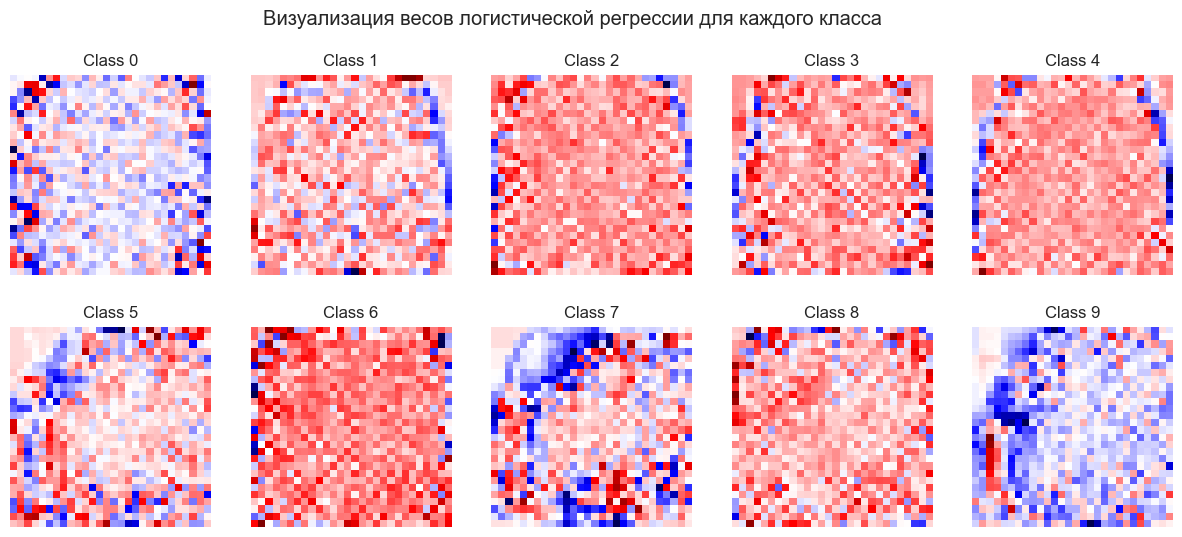

In [ ]:
# Логистическая регрессия в многоклассовой классификации (One-vs-All) учится выделять черты, отличающие каждый класс от остальных
# Хоть модель и линейная, она может уловить базовые паттерны, например, очертания или контуры, характерные для каждого класса

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import fetch_openml

dataset = pd.read_csv('train.csv')
X = dataset.drop(['Category', 'Id'], axis=1).values
y = dataset['Category'].values

model = LogisticRegression(max_iter=1000, solver='saga', multi_class='ovr')
model.fit(X, y)

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    weights = model.coef_[i].reshape(28, 28)
    ax = axes[i // 5, i % 5]
    ax.imshow(weights, cmap='seismic', interpolation='nearest')
    ax.set_title(f'Class {i}')
    ax.axis('off')

plt.suptitle("Визуализация весов логистической регрессии для каждого класса")
plt.show()

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.

In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

data = pd.read_csv('train.csv')
train_data = data.iloc[:50000]
test_data = data.iloc[50000:]
X_train_full = train_data.drop(['Category', 'Id'], axis=1).values
y_train_full = train_data['Category'].values
X_test = test_data.drop(['Category', 'Id'], axis=1).values
y_test = test_data['Category'].values

scaler = StandardScaler()
X_train_full_scaled = scaler.fit_transform(X_train_full)
X_test_scaled = scaler.transform(X_test)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full_scaled, y_train_full, train_size=10000, stratify=y_train_full, random_state=42
)

rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_val)
rf_accuracy = accuracy_score(y_val, y_pred_rf)
print(f"Точность Random Forest: {rf_accuracy:.4f}")

param_distributions = {
    'n_estimators': [100, 150],
    'max_depth': [None, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt'],
}

random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_distributions,
    n_iter=5,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search_rf.fit(X_train, y_train)

print("Лучшие параметры Random Forest:")
print(random_search_rf.best_params_)

best_rf = random_search_rf.best_estimator_
y_pred_best_rf_val = best_rf.predict(X_val)
best_rf_accuracy_val = accuracy_score(y_val, y_pred_best_rf_val)

print(f"Лучшая точность Random Forest: {best_rf_accuracy_val:.4f}")

best_rf_full = RandomForestClassifier(
    **random_search_rf.best_params_,
    random_state=42,
    n_jobs=-1
)
best_rf_full.fit(X_train_full_scaled, y_train_full)
y_pred_best_rf = best_rf_full.predict(X_test_scaled)
best_rf_accuracy = accuracy_score(y_test, y_pred_best_rf)

print(f"Лучшая точность Random Forest: {best_rf_accuracy:.4f}")
print(classification_report(y_test, y_pred_best_rf))

Точность Random Forest: 0.8591
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  12.7s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  15.8s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  16.4s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  16.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  18.1s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150; total time=  18.3s
[CV] END max_depth=None, max_features=sqrt, min_samples